<a href="https://colab.research.google.com/github/himanshira/Deep-Learning/blob/main/Enhancing_Dental_X_rays_with_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task: Build an autoencoder model to improve the clarity of dental X-rays (denoise theX-rays) using the dental panoramic dataset.

###This dataset consists of anonymized and de-identified panoramic dental X-rays of 116patients, taken at Noor Medical Imaging Center, Qom, Iran. The subjects cover a wide rangeof dental conditions from healthy, to partial, and complete edentulous cases. The mandibles of all cases are manually segmented by two dentists. The dataset is saved in compressedNumPy format which when loaded using numpy.load will give you x_train, y_train, x_test andy_test NumPy arrays respectively.

- Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras import losses

##Load the Dental-Panaromic-Autoencoder.npz dataset using NumPy.load. Extract x_train, y_train, x_test and y_test numpy arrays from the dataset


In [ ]:
file_path = '/content/Dental-Panaromic-Autoencoder.npz'

try:
  with np.load(file_path) as data:
    print(f"Successfully loaded: {file_path}")
    print("Arrays contained in npz files", data.files)

    if 'x_train' in data and 'y_train' in data and 'x_test' in data and 'y_test' in data:
      x_train = data['x_train']
      y_train = data['y_train']
      y_test = data['y_test']
      x_test = data['x_test']

      print("\nExtracted Data")
      print("x_train shape:", x_train.shape)
      print("y_train shape:", y_train.shape)
      print("x_test shape:", x_test.shape)
      print("y_test shape:", y_test.shape)
      #print("\nFirst five elements in rtain data", x_train[:5])
    else:
      print("\nError: One or more array are not in x_train, y_train, x_test and y_test.")
      print("\nPease inspect data.files output above to see available keys.")

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure the .npz file is in the same directory as this Python script, or provide the full path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded: /content/Dental-Panaromic-Autoencoder.npz
Arrays contained in npz files ['x_train', 'y_train', 'x_test', 'y_test']

Extracted Data
x_train shape: (92, 256, 256, 3)
y_train shape: (92,)
x_test shape: (24, 256, 256, 3)
y_test shape: (24,)


 ## A noisy version of the dataset will be created by applying random noise to each image. With a noise factor of 0.2, add noise to the signal by multiplying the noise factor and random values from a normal distribution. Clip the signal values between 0 and 1


In [ ]:
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

# The tf.clip_by_value operation is used to constrain the pixel values of your noisy images to a specific range

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)


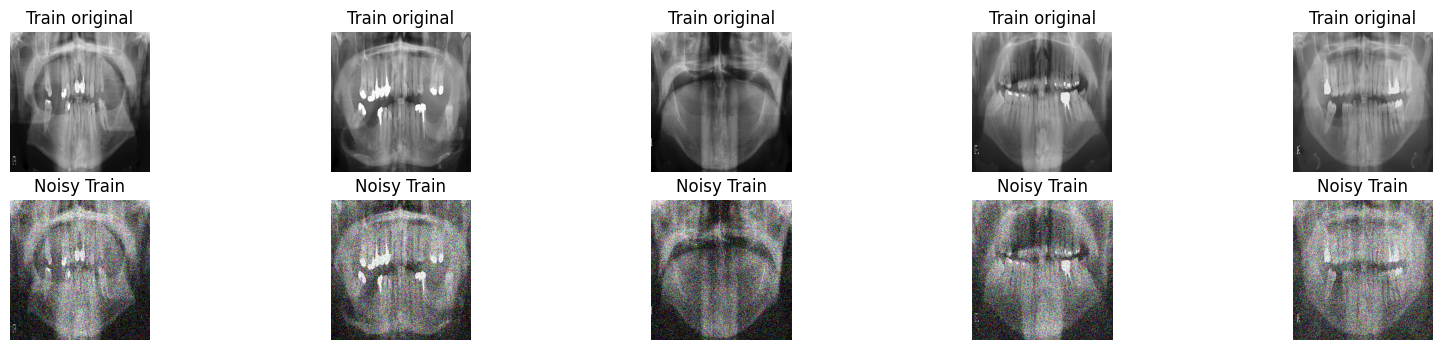

In [ ]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):

  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_train[i])
  plt.title("Train original")
  plt.axis('off')

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(x_train_noisy[i])
  plt.title("Noisy Train")
  plt.axis('off')

plt.show()

In [ ]:
# Train an autoencoder using the noisy image as the input and the original image as the
#destination. The images are shaped 256x256 in RGB scale
# Create a Denoise class inherited from Keras Model



class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
# compile the model


autoencoder.compile(loss=losses.MeanSquaredError(), optimizer='adam')
autoencoder.summary()

Model: "denoise"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 32)     │        20,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,256 (79.12 KB)

 Trainable params: 20,256 (79.12 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 50

history = autoencoder.fit(x_train_noisy, x_train, epochs=epochs,
                batch_size=128,
                validation_data=(x_test_noisy, x_test))

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0089 - val_loss: 0.0091
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step - loss: 0.0085 - val_loss: 0.0087
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 0.0051 - val_loss:

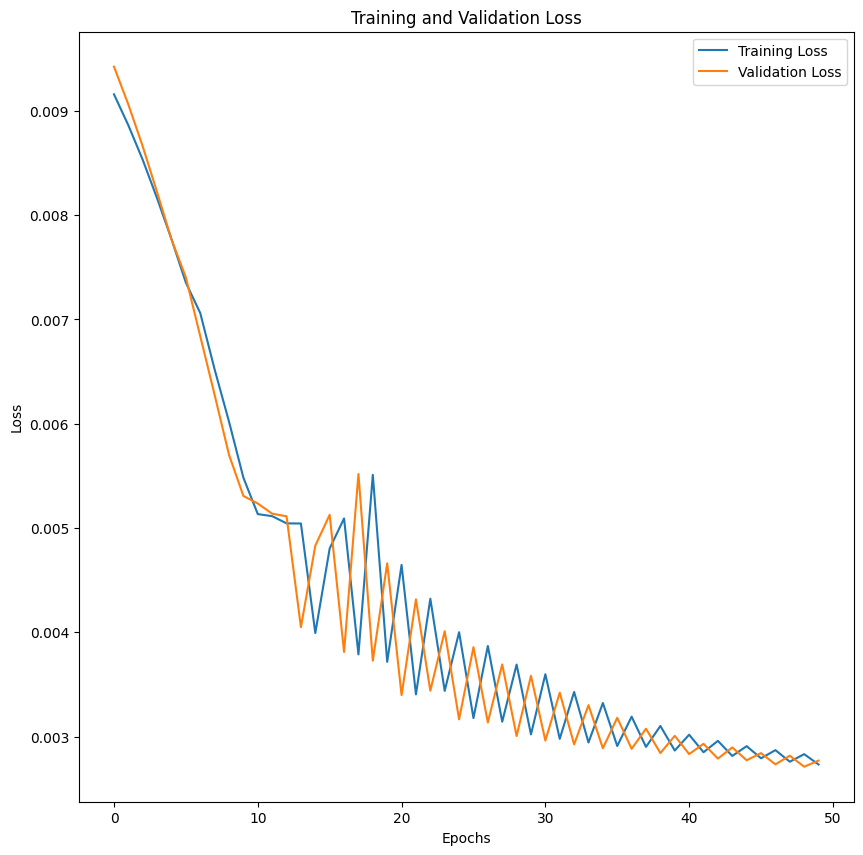

In [ ]:
# Plot training and validation MAE and loss against epochs
epochs = 50
epochs = range(epochs)

plt.figure(figsize=(10, 10))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

 #Pass the x_test into the encoder
# Pass the encoded images into the decoder. This step gives the decoded images tha are reconstructed from the original.

encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# Evaluate the autoencoder model on x_test

evaluation = autoencoder.evaluate(x_test, y_test, verbose=0)
print("Evaluation on x_test:", evaluation)

Evaluation on x_test: 0.3479677140712738


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


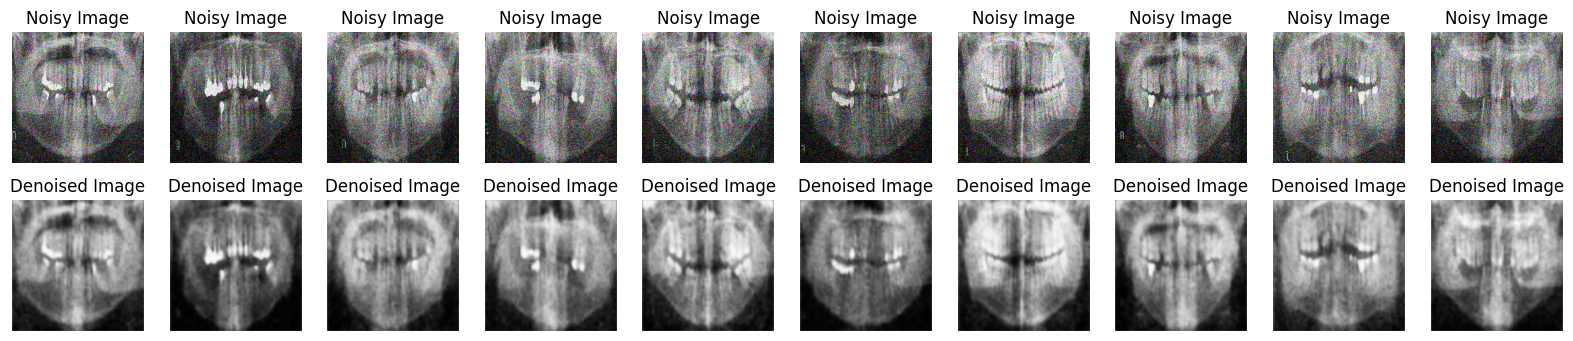

In [ ]:
#Plot both the first 10 noisy images (x_test_noisy) and images without noise produced by
#the autoencoder. Check how well the AutoEncoder model has done the job with
#denoising.

predicted_images = autoencoder.predict(x_test_noisy)

# #Plot both the first 10 noisy images (x_test_noisy) and images without noise produced by
#the autoencoder.

plt.figure(figsize=(20, 4))
for i in range(10):
  ax = plt.subplot(2, 10, i+1)
  plt.imshow(x_test_noisy[i])
  plt.title("Noisy Image")
  plt.axis('off')

  ax = plt.subplot(2, 10, i+11)
  plt.imshow(predicted_images[i])
  plt.title("Denoised Image")
  plt.axis('off')
  plt.gray()
plt.show()